<a href="https://colab.research.google.com/github/pacslab/conc-value-perf-modelling/blob/main/experiments/parser/ConcValueExpParser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing The Notebook

In this section, we will be preparing the environment to run the code in. The path to this notebook in the GitHub repo is `experiments/parser/ConcValueExpParser.ipynb`.

## Mount Google Drive and Create Static Links

In [1]:
# mount drive to get started
from google.colab import drive
drive.mount('/mnt/drive')

# create static links to the drive folder
!sudo ln -sf /mnt/drive/MyDrive/Colab\ Notebooks/conc_val_res results_zips

Mounted at /mnt/drive


In [2]:
zip_file_name = "03_res1_cpu_10k_ps_istio.zip"
plot_dl_exp_figs = False
dl_overall_figs = False

# extract results
!rm -r results
!unzip -o results_zips/{zip_file_name} > /dev/null

rm: cannot remove 'results': No such file or directory


In [3]:
# # unmount drive when we are done
# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

## Install Necessary Dependencies

In [4]:
%%writefile requirements.txt

pacswg>=0.1.16
pacsltk>=0.1.13
tqdm>=4.36.1

Writing requirements.txt


In [5]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 512kB 6.4MB/s 
     |████████████████████████████████| 143kB 21.9MB/s 
     |████████████████████████████████| 133kB 28.4MB/s 
     |████████████████████████████████| 7.1MB 22.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: convertdate 2.2.0 has requirement pytz<2020,>=2014.10, but you'll have pytz 2020.4 which is incompatible.


In [6]:
# import tqdm
import tqdm

# quietly deep-reload tqdm
import sys
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout

## Imports and Initializations

In [7]:
# plotting imports (needs to be before matplotlib)
import pacsltk.pacs_util as pacs_util
pacs_util.prepare_matplotlib_cycler()

# general imports
import os

# parsing imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# other seaborn aesthetic options: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_style("whitegrid")

# for datetime analysis
from datetime import datetime
import pytz

# for file processing
import glob
import json

# for better printing of variables
from IPython.display import display

## Utility Functions

In [8]:
def save_json_file(data, filename):
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)

def load_json_file(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

# Plotting Arrival Rate Plots

In [9]:
# all constants
results_folder = './results/'
my_timezone = 'US/Eastern'

# Prepare for plots and make directories
figs_folder = "figs"
!rm -r {figs_folder}
!mkdir -p {figs_folder}

# Prepare for overall plots and make directories
figs_overall_folder = "figs_overall"
!rm -r {figs_overall_folder}
!mkdir -p {figs_overall_folder}

rm: cannot remove 'figs': No such file or directory
rm: cannot remove 'figs_overall': No such file or directory


In [10]:
def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
              x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def get_fig_overall_path(x): return (os.path.join(figs_overall_folder, "exp" +
          x + ".png"), os.path.join(figs_overall_folder, "exp" + x + ".pdf"))

def tmp_fig_overall_save(fig_name):
    paths = get_fig_overall_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

## Developing Analysis of An Experiment Log

In [11]:
# list all results
csv_file_list = glob.glob(f'{results_folder}*.csv')
exp_list = list(map(lambda x: x.replace(results_folder, '').replace('.csv',''), csv_file_list))
# sort based on experiment name
exp_list.sort()
# print('List of Experiments Analyzing:\n')
# exp_list

In [12]:
# parsing functions
def load_exp_file(exp_name, results_folder=results_folder):
  csv_file = f'{results_folder}{exp_name}.csv'
  df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
  # remove -1's where we have had an exception in our requester
  df = df[df['client_start_time'] > 0]
  df = df[df['client_end_time'] > 0]
  df['client_elapsed_time'] = df['client_elapsed_time'] * 1000
  epoch_cols_list = ['client_start_time', 'client_end_time',]
  datetimes = {}
  for epoch_col in epoch_cols_list:
      times = df[epoch_col].apply(lambda x: datetime.fromtimestamp(x).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None))
      times = pd.to_datetime(times.dt.to_pydatetime())
      df[epoch_col + '_dt'] = times
      datetimes[epoch_col] = times

  df = df.set_index('client_start_time_dt')
  return df

def load_exp_json_files(exp_name, results_folder=results_folder):
  results = []
  # load all postfixes
  for pf in ['_conc.json', '_stats.json', '_info.json']:
    results.append(load_json_file(results_folder + exp_name + pf))
  # return the results as tuple
  return tuple(results)

def convert_timestamp(ts):
  return datetime.fromtimestamp(ts/1000).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None)

def convert_hist_to_values(h):
  # get values based on estimated hist fetched
  values = []
  for x,y in zip(h['x'], h['y']):
    values += [x] * int(y)
  return values

def plot_client_data(exp_df_client, window='10s'):
  plt.figure(figsize=(8,4))
  exp_df_client['client_elapsed_time'].resample(window).mean().plot()
  plt.ylabel(f'RT ({window} window)')
  plt.xlabel('Time')
  tmp_fig_save("_" + exp_name + "_rt")

def parse_conc_data(conc_data):
  conc_df = pd.DataFrame(data=conc_data)
  conc_df['report_time'] = conc_df['report_time'].apply(convert_timestamp)
  conc_df = conc_df.set_index(conc_df['report_time'])

  client_conc_per_server = conc_df['client_conc'] / conc_df['running_instance_count']
  # we need to remove inf because server count might be zero
  client_conc_per_server = client_conc_per_server.replace([np.inf, -np.inf], np.nan)
  conc_df['client_conc_per_server'] = client_conc_per_server

  if 'start_conc' in conc_df.columns:
    conc_df['client_conc'] = conc_df['start_conc']

  return conc_df

def plot_server_conc(conc_df):
  server_conc_avg = conc_df['avg'].mean()

  plt.figure(figsize=(8,4))
  conc_df['avg'].plot(label='Conc Average')
  plt.xlabel('Time')
  plt.ylabel('Server Concurrency')
  plt.axhline(y=server_conc_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  tmp_fig_save("_" + exp_name + "_server_conc")

def plot_client_conc(conc_df, client_conc_avg):
  plt.figure(figsize=(8,4))
  conc_df['client_conc'].plot(label='Client Conc')
  plt.axhline(y=client_conc_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Client Concurrency')
  tmp_fig_save("_" + exp_name + "_client_conc")

def plot_conc_per_server(conc_df, client_conc_per_server_avg):
  client_conc_per_server = conc_df['client_conc_per_server']
  plt.figure(figsize=(8,4))
  client_conc_per_server.plot(label='Conc/Server')
  plt.xlabel('Time')
  plt.ylabel('Conc Per Server')
  plt.axhline(y=client_conc_per_server_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  tmp_fig_save("_" + exp_name + "_conc_per_server")
  # now, plot the histogram
  plt.figure(figsize=(8,4))
  values = client_conc_per_server.values
  plt.hist(values, bins=10, label='Conc Per Server')
  plt.xlabel('Time')
  plt.ylabel('Conc Per Server')
  plt.axvline(x=client_conc_per_server_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  tmp_fig_save("_" + exp_name + "_conc_per_server_hist")

def plot_running_inst_count(conc_df, inst_count_avg):
  plt.figure(figsize=(8,4))
  conc_df['running_instance_count'].plot(label='Inst Count')
  plt.axhline(y=inst_count_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Instance Count')
  tmp_fig_save("_" + exp_name + "_inst_count")

  plt.figure(figsize=(8,4))
  plt.title('Histogram of Running Instances')
  plt.hist(conc_df['running_instance_count'], bins=10)
  plt.xlabel('Instance Count')
  plt.ylabel('Frequency')
  tmp_fig_save("_" + exp_name + "_inst_count_hist")

def get_service_time_values(stats_data):
  h = stats_data['service_time_hists']
  # add 25 because we rounded down to nearest 50ms
  h['x'] = list(map(lambda x: x+25, h['x']))
  values = convert_hist_to_values(h)
  return values

def plot_service_time_hist(stats_data):
  values = get_service_time_values(stats_data)

  plt.figure(figsize=(8,4))
  plt.title('Histogram of Service Times')
  plt.hist(values, bins=10)
  plt.xlabel('Service Time')
  plt.ylabel('Frequency')
  tmp_fig_save("_" + exp_name + "_service_time_hist")

def plot_server_conc_hist(stats_data):
  h = stats_data['conc_hists']
  values = convert_hist_to_values(h)

  plt.figure(figsize=(8,4))
  plt.title('Histogram of Server Concurrency')
  plt.hist(values, bins=10)
  plt.xlabel('Server Concurrency')
  plt.ylabel('Frequency')
  tmp_fig_save("_" + exp_name + "_server_conc_hist")

#################################################
def parse_experiment_files(exp_name, plot=True, debug=False):
  conc_data, stats_data, info_data = load_exp_json_files(exp_name)

  # adding extra metadata and print
  info_data['rps'] = info_data['rps_list'][0]
  if debug:
    print('input info data:')
    display(info_data)

  # plot data from client
  exp_df_client = load_exp_file(exp_name)
  if debug:
    print('Experiment Client Dataframe:')
    display(exp_df_client.head())
  if plot:
    plot_client_data(exp_df_client)

  # parse concurrency data
  conc_df = parse_conc_data(conc_data)
  if debug:
    print('Concurrency Dataframe:')
    display(conc_df.head())

  # plot server concurrency
  if plot:
    plot_server_conc(conc_df)
  # plot client concurrency
  client_conc_avg = conc_df['client_conc'].mean()
  if plot:
    plot_client_conc(conc_df, client_conc_avg)
  # plot conc per server
  client_conc_per_server_avg = conc_df['client_conc_per_server'].mean()
  if plot:
    plot_conc_per_server(conc_df, client_conc_per_server_avg)

  # plot number of running instances
  inst_count_avg = conc_df['running_instance_count'].mean()
  if plot:
    plot_running_inst_count(conc_df, inst_count_avg)

  if plot:
    # plot long-term service time and server concurrency histogram
    plot_service_time_hist(stats_data)
    plot_server_conc_hist(stats_data)


  # get average response time
  resp_time_avg = exp_df_client['client_elapsed_time'].mean()
  # get average service time
  service_values = get_service_time_values(stats_data)
  service_time_avg = np.mean(service_values)

  # update info data
  info_data.update({
      'client_conc_avg': client_conc_avg,
      'client_conc_per_server_avg': client_conc_per_server_avg,
      'inst_count_avg': inst_count_avg,
      'resp_time_avg': resp_time_avg,
      'service_time_avg': service_time_avg,
      'exp_name': exp_name,
  })

  return info_data

# running sample parsing
exp_name = exp_list[0]
parse_experiment_files(exp_name, plot=False)
# add this if we don't want to see the plots
# plt.close('all')

{'client_conc_avg': 0.18032786885245902,
 'client_conc_per_server_avg': 0.18181818181818182,
 'concurrency_limit': 0.0,
 'concurrency_target': 8.0,
 'concurrency_target_utilization': 70.0,
 'exp_name': 'res-2020-12-19_21-32-16',
 'inst_count_avg': 0.9918032786885246,
 'resp_time_avg': 101.10364520115408,
 'rps': 1,
 'rps_list': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'service_time_avg': 55.040485829959515}

## Plot Overall Experiment Results

In [13]:
results_arr = []
for exp_name in tqdm(exp_list):
  try:
    result = parse_experiment_files(exp_name, plot=plot_dl_exp_figs)
    plt.close('all')
    results_arr.append(result)
  except:
    pass

# parsed data frame
pdf = pd.DataFrame(data=results_arr)
pdf.head()

100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


,concurrency_target,concurrency_limit,concurrency_target_utilization,rps_list,rps,client_conc_avg,client_conc_per_server_avg,inst_count_avg,resp_time_avg,service_time_avg,exp_name
0,8.0,0.0,70.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.180328,0.181818,0.991803,101.103645,55.040486,res-2020-12-19_21-32-16
1,8.0,0.0,70.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",3,0.132231,0.132231,1.000000,73.138648,60.639615,res-2020-12-19_21-52-25
2,8.0,0.0,70.0,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",5,0.876033,0.812500,1.404959,131.567388,76.718329,res-2020-12-19_22-12-30
3,8.0,0.0,70.0,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",7,0.716667,0.677871,1.158333,118.915708,91.973032,res-2020-12-19_22-32-35
4,8.0,0.0,70.0,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...",9,2.446281,2.023909,2.570248,224.015156,125.205724,res-2020-12-19_22-52-38


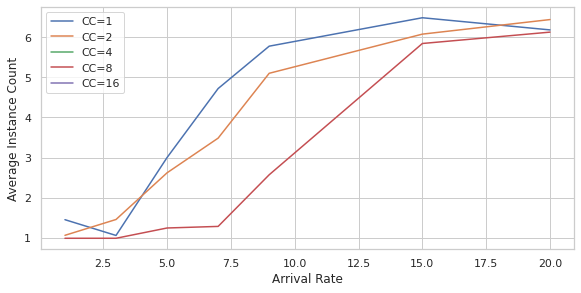

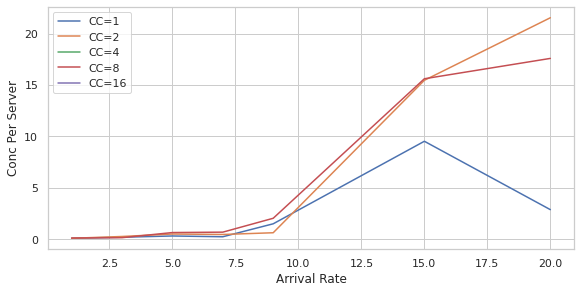

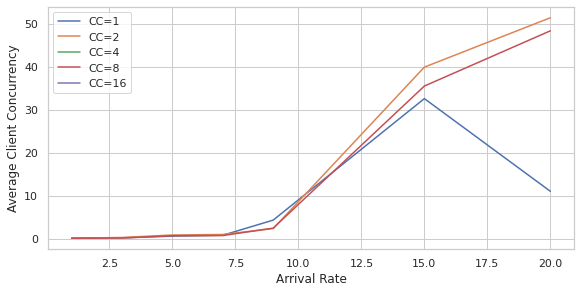

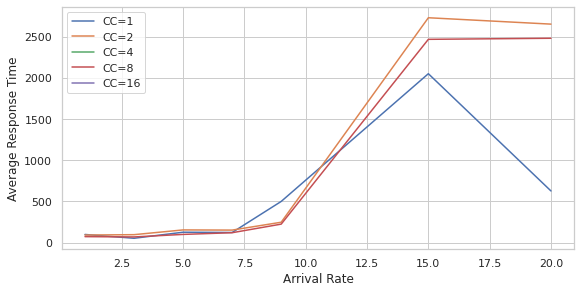

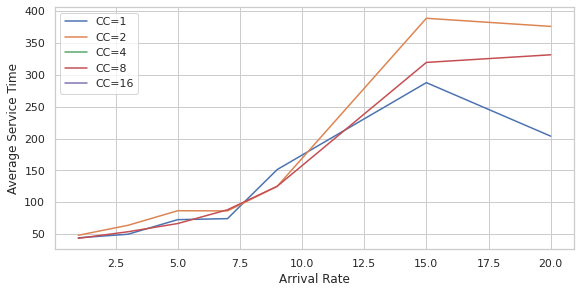

In [14]:
def get_sub_pdf(target, limit, util):
  sub_pdf = pdf.loc[pdf['concurrency_target'] == target]
  sub_pdf = sub_pdf.loc[sub_pdf['concurrency_limit'] == limit]
  sub_pdf = sub_pdf.loc[sub_pdf['concurrency_target_utilization'] == util]
  return sub_pdf

def plot_arrival_rate_vs_col(opts, col_name):
  sub_pdf = get_sub_pdf(*opts)
  sub_pdf = sub_pdf.sort_values(by='rps')
  sub_pdf = sub_pdf.groupby('rps').mean()
  sub_pdf = sub_pdf.reset_index()
  label = f"CC={opts[0]}"
  plt.plot(sub_pdf['rps'], sub_pdf[col_name], label=label)


# Configs: target, limit, util
configs = [(cc, 0, 70) for cc in [1,2,4,8,16]]
# arrival rate vs x plot (xlabel, col_name, file_name)
arr_rate_plt_configs = [
  ('Average Instance Count','inst_count_avg','_arr_vs_inst_count'),
  ('Conc Per Server','client_conc_per_server_avg','_arr_vs_conc_per_server'),
  ('Average Client Concurrency','client_conc_avg','_arr_vs_client_conc'),
  ('Average Response Time','resp_time_avg','_arr_vs_resp_time'),
  ('Average Service Time','service_time_avg','_arr_vs_service_time'),
]

for plt_config in arr_rate_plt_configs:
  plt.figure(figsize=(8,4))
  for config in configs:
    plot_arrival_rate_vs_col(config, plt_config[1])
  plt.tight_layout()
  plt.legend()
  plt.xlabel('Arrival Rate')
  plt.ylabel(plt_config[0])
  tmp_fig_overall_save("_" + exp_name + plt_config[2])

# Download Figures

This section will execute the necessary code for downloading the figures generated in this notebook.

In [15]:
from google.colab import files

def upload_file(file_path):
  !curl --upload-file {file_path} https://free.keep.sh

if plot_dl_exp_figs:
  !rm figs.zip
  !zip -q figs.zip figs/*
  upload_file("figs.zip")
  # try:
  #   files.download('figs.zip')
  # except:
  #   pass

if dl_overall_figs:
  !rm figs_overall.zip
  !zip -q figs_overall.zip figs_overall/*
  upload_file("figs_overall.zip")
  # try:
  #   files.download('figs_overall.zip')
  # except:
  #   pass

# Scratch Cell Snippets

These are a few code snippets that could be useful when working with scratch cells to do quick checks.

To load an image for checking what we are saving.
```py
from IPython.display import Image
Image(filename='test.png')
```

To find the experiment name for an specific log:
```py
# conc, conc_limit, conc_target
s = get_sub_pdf(2,0,70)
s[s['rps'] == 15]
```

To draw plots for a specific experiment:
```py
parse_experiment_files('res-2020-12-16_15-54-58', plot=True)
```

To show the contents of a png file:
```py
from IPython.display import Image
Image(filename='file_path.png')
```